# k-means clustering

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mode

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata

def gini(x):
    "See https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity"
    unique, counts = np.unique(x, return_counts=True)
    n = len(x)
    return 1 - np.sum( (counts / n)**2 )

## MNIST digits

In [72]:
df_digits = pd.read_csv("data/mnist-10k-sample.csv")
n = 3000
df_subset = df_digits.sample(n=n, replace=False)
X = df_subset.drop('digit', axis=1) # get just pixels
y = df_subset['digit']

In [73]:
def imgrid(images,targets):
    fig, axes = plt.subplots(5, 5, figsize=(4, 4)) # make 5x5 grid of plots
    for i, ax in enumerate(axes.flat):
        img_as_row = images.iloc[i].values
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, targets[i], color='#313695', fontsize=18)

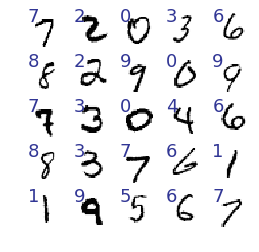

In [74]:
imgrid(X,targets=y.values)

In [75]:
X = normalize(X)

In [80]:
for i in range(10):
    df_subset = df_digits.sample(n=1000, replace=False)
    X = df_subset.drop('digit', axis=1) # get just pixels
    y = df_subset['digit']
    X = normalize(X)
    kmeans = KMeans(10, init='random')
    kmeans.fit(X)
    y_pred = kmeans.predict(X)

    # digit_idxs[d] tells us which X indexes are for digit d
    digit_idxs = [np.where(y==d)[0] for d in range(10)]
    # we don't know which of k clusters is for which digit but we can
    # ask for the impurity of y_pred associated with known digit d group
    print([round(gini(y_pred[digit_idxs[d]]),2) for d in range(10)])

[0.27, 0.55, 0.43, 0.34, 0.46, 0.65, 0.3, 0.53, 0.54, 0.66]
[0.27, 0.51, 0.24, 0.41, 0.54, 0.58, 0.48, 0.53, 0.57, 0.71]
[0.36, 0.51, 0.33, 0.52, 0.52, 0.72, 0.24, 0.4, 0.47, 0.61]
[0.49, 0.53, 0.31, 0.56, 0.59, 0.68, 0.44, 0.51, 0.45, 0.57]
[0.32, 0.53, 0.31, 0.5, 0.54, 0.69, 0.44, 0.45, 0.54, 0.55]
[0.21, 0.54, 0.29, 0.17, 0.69, 0.76, 0.34, 0.54, 0.61, 0.68]
[0.31, 0.54, 0.34, 0.4, 0.57, 0.69, 0.52, 0.48, 0.58, 0.66]
[0.29, 0.51, 0.46, 0.54, 0.63, 0.71, 0.38, 0.48, 0.67, 0.65]
[0.38, 0.52, 0.37, 0.53, 0.55, 0.62, 0.4, 0.47, 0.48, 0.61]
[0.48, 0.5, 0.37, 0.59, 0.64, 0.72, 0.54, 0.61, 0.63, 0.62]


In [92]:
print(y_pred[digit_idxs[0]])
print('gini =', gini(y_pred[digit_idxs[0]]))

[9 5 5 5 5 5 9 9 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 9 5 5 9 5 5 5 5 9
 5 5 5 9 5 5 8 5 5 9 5 5 5 9 5 5 9 9 5 5 5 5 5 9 5 9 5 9 9 9 2 2 0 9 5 5 5
 8 9 5 9 9 5 5 9 5 5 5 9 9 5 5 9 5 5 9 5 5 5 9 5 9]
gini = 0.48219569431690645


In [93]:
print(y_pred[digit_idxs[9]])
print('gini =', gini(y_pred[digit_idxs[9]]))

[1 6 8 6 1 1 1 1 8 6 6 8 4 6 6 8 1 6 3 6 6 6 6 6 1 6 6 8 1 1 4 1 6 8 1 8 1
 6 8 6 6 6 3 1 1 8 6 3 6 8 6 8 8 8 1 5 6 6 1 6 6 6 1 6 1 6 6 6 1 1 1 6 6 6
 6 8 6 6 6 6 6 1 1 1 8 6 6 1 1 6 6 6 6 6 1 6 6 6 8 6 6 8 6 8 8 6 6 1 6 6 6
 6 6 1 6 6 6 6 8 6 1 3 6 6]
gini = 0.6221383975026016


In [78]:
np.where(y==2)[0]

array([   1,    6,   41,   49,   72,   74,   79,   82,   88,   95,  106,
        114,  122,  130,  133,  139,  151,  179,  181,  182,  206,  217,
        237,  246,  263,  270,  289,  293,  295,  308,  310,  314,  315,
        322,  333,  339,  340,  342,  352,  354,  355,  356,  382,  383,
        386,  406,  423,  430,  437,  449,  451,  452,  453,  459,  461,
        463,  470,  489,  500,  505,  510,  512,  521,  523,  553,  575,
        578,  580,  594,  624,  645,  650,  662,  663,  677,  685,  704,
        713,  727,  730,  745,  772,  775,  801,  839,  848,  849,  851,
        858,  859,  864,  879,  895,  897,  919,  926,  942,  959,  994,
       1019, 1029, 1038, 1065, 1074, 1075, 1086, 1092, 1093, 1102, 1104,
       1105, 1108, 1109, 1116, 1120, 1121, 1125, 1136, 1150, 1157, 1159,
       1168, 1171, 1178, 1182, 1200, 1233, 1234, 1274, 1292, 1323, 1329,
       1346, 1353, 1361, 1366, 1375, 1382, 1386, 1404, 1407, 1423, 1424,
       1426, 1449, 1453, 1458, 1463, 1480, 1484, 14

In [10]:
results = []
for i in range(10):
    n = 1000
    df_subset = df_digits.sample(n=n, replace=False)
    X = df_subset.drop('digit', axis=1) # get just pixels
    X = normalize(X)
    y = df_subset['digit']
    kmeans = KMeans(10, init='random')
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    correct = np.sum(y!=y_pred)
    print(f"{correct}/{n}={100*correct/n:.1f}% correct")
    results.append(correct)
print(f"Avg {np.mean(results)}/{n}={100*correct/n:.1f}% correct, stddev {100*np.std(results)/n:.2f}")

932/1000=93.2% correct
961/1000=96.1% correct
773/1000=77.3% correct
875/1000=87.5% correct


KeyboardInterrupt: 

## Breast cancer data

In [11]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [12]:
cancer = np.where(y==0)[0]
benign = np.where(y==1)[0]
len(cancer), len(benign)

(212, 357)

In [34]:
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X)
y_pred = kmeans.predict(X)

true_benign = np.unique(y_pred[benign], return_counts=True)[1]
true_cancer = np.unique(y_pred[cancer], return_counts=True)[1]
conf_matrix = np.concatenate([[true_benign],
                              [true_cancer]], axis=0)

pd.DataFrame(conf_matrix)

,0,1
0,356,1
1,82,130


In [48]:
gini(y_pred[benign]), gini(y_pred[cancer])

(0.0055865483448280795, 0.4743681025275899)

In [ ]:
X.shape

## Image color vector quantization

From [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html)

Modified by parrt to load custom image.

In [ ]:
%config InlineBackend.figure_formats = ['svg']

# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from skimage.io import imread
from time import time

def demo(n_colors = 10):
    parrt = imread("parrt.jpg")

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    parrt = np.array(parrt, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(parrt.shape)
    assert d == 3
    image_array = np.reshape(parrt, (w * h, d))

    print("Fitting model on a small sub-sample of the data")
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=0)[:2000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    print("done in %0.3fs." % (time() - t0))

    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    t0 = time()
    labels = kmeans.predict(image_array)
    print("done in %0.3fs." % (time() - t0))


    codebook_random = shuffle(image_array, random_state=0)[:n_colors]
    print("Predicting color indices on the full image (random)")
    t0 = time()
    labels_random = pairwise_distances_argmin(codebook_random,
                                              image_array,
                                              axis=0)
    print("done in %0.3fs." % (time() - t0))


    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h, d))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image

    # Display all results, alongside original image
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].axis('off')
    axes[0].set_title(f'Original image\n(96,615 colors)', fontsize=14)
    axes[0].imshow(parrt)

    axes[1].axis('off')
    axes[1].set_title(f'Quantized image\n({n_colors} colors, k-Means)', fontsize=14)
    axes[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

    axes[2].axis('off')
    axes[2].set_title(f'Quantized image\n({n_colors} colors, at random)', fontsize=14)
    axes[2].imshow(recreate_image(codebook_random, labels_random, w, h))
    plt.tight_layout()
    plt.savefig("/Users/parrt/Desktop/parrt-quantized.jpg", bbox_inches=0)
    plt.show()

In [ ]:
demo(n_colors=10)

In [ ]:
demo(n_colors=4)